Date: 25/07/2022

Author: @kavindu404

# Multi Class Classification From Scratch (Part 2)

Welcome to part 2 of the mini blog series on multi class classification from scratch. In first part, we used pixel similarity to predict the class of the digit. In this one, we will be using a simle neural network from scratch. Same as the last one, we start with importing fastai vision library and stacking up the data w.r.t classes like we did in the previous part.

In [1]:
from fastai.vision.all import *

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

In [3]:
zeros = (path/'training'/'0').ls().sorted()
ones = (path/'training'/'1').ls().sorted()
twos = (path/'training'/'2').ls().sorted()
threes = (path/'training'/'3').ls().sorted()
fours = (path/'training'/'4').ls().sorted()
fives = (path/'training'/'5').ls().sorted()
sixes = (path/'training'/'6').ls().sorted()
sevens = (path/'training'/'7').ls().sorted()
eights = (path/'training'/'8').ls().sorted()
nines = (path/'training'/'9').ls().sorted()

In [4]:
stacked_zeros = torch.stack([tensor(Image.open(o)) for o in zeros]).float()/255
stacked_ones = torch.stack([tensor(Image.open(o)) for o in ones]).float()/255
stacked_twos = torch.stack([tensor(Image.open(o)) for o in twos]).float()/255
stacked_threes = torch.stack([tensor(Image.open(o)) for o in threes]).float()/255
stacked_fours = torch.stack([tensor(Image.open(o)) for o in fours]).float()/255
stacked_fives = torch.stack([tensor(Image.open(o)) for o in fives]).float()/255
stacked_sixes = torch.stack([tensor(Image.open(o)) for o in sixes]).float()/255
stacked_sevens = torch.stack([tensor(Image.open(o)) for o in sevens]).float()/255
stacked_eights = torch.stack([tensor(Image.open(o)) for o in eights]).float()/255
stacked_nines = torch.stack([tensor(Image.open(o)) for o in nines]).float()/255

In [6]:
train_x = torch.cat([stacked_zeros, stacked_ones, stacked_twos, stacked_threes, stacked_fours, stacked_fives, stacked_sixes, stacked_sevens, stacked_eights, stacked_nines]).view(-1, 28*28)
train_y = tensor([0]*len(zeros)+[1]*len(ones)+[2]*len(twos)+[3]*len(threes)+[4]*len(fours)+[5]*len(fives)+[6]*len(sixes)+[7]*len(sevens)+[8]*len(eights)+[9]*len(nines)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

Here, we create a dataset by coupling the image with its label. We do the same for the validation set.

In [7]:
train_dset = list(zip(train_x, train_y))
x, y = train_dset[100]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [8]:
valid_zeros = (path/'testing'/'0').ls().sorted()
valid_ones = (path/'testing'/'1').ls().sorted()
valid_twos = (path/'testing'/'2').ls().sorted()
valid_threes = (path/'testing'/'3').ls().sorted()
valid_fours = (path/'testing'/'4').ls().sorted()
valid_fives = (path/'testing'/'5').ls().sorted()
valid_sixes = (path/'testing'/'6').ls().sorted()
valid_sevens = (path/'testing'/'7').ls().sorted()
valid_eights = (path/'testing'/'8').ls().sorted()
valid_nines = (path/'testing'/'9').ls().sorted()

In [9]:
valid_stacked_zeros = torch.stack([tensor(Image.open(o)) for o in valid_zeros]).float()/255
valid_stacked_ones = torch.stack([tensor(Image.open(o)) for o in valid_ones]).float()/255
valid_stacked_twos = torch.stack([tensor(Image.open(o)) for o in valid_twos]).float()/255
valid_stacked_threes = torch.stack([tensor(Image.open(o)) for o in valid_threes]).float()/255
valid_stacked_fours = torch.stack([tensor(Image.open(o)) for o in valid_fours]).float()/255
valid_stacked_fives = torch.stack([tensor(Image.open(o)) for o in valid_fives]).float()/255
valid_stacked_sixes = torch.stack([tensor(Image.open(o)) for o in valid_sixes]).float()/255
valid_stacked_sevens = torch.stack([tensor(Image.open(o)) for o in valid_sevens]).float()/255
valid_stacked_eights = torch.stack([tensor(Image.open(o)) for o in valid_eights]).float()/255
valid_stacked_nines = torch.stack([tensor(Image.open(o)) for o in valid_nines]).float()/255

In [10]:
valid_x = torch.cat([valid_stacked_zeros, valid_stacked_ones, valid_stacked_twos, valid_stacked_threes, valid_stacked_fours, valid_stacked_fives, valid_stacked_sixes, valid_stacked_sevens, valid_stacked_eights, valid_stacked_nines]).view(-1, 28*28)
valid_y = tensor([0]*len(valid_zeros)+[1]*len(valid_ones)+[2]*len(valid_twos)+[3]*len(valid_threes)+[4]*len(valid_fours)+[5]*len(valid_fives)+[6]*len(valid_sixes)+[7]*len(valid_sevens)+[8]*len(valid_eights)+[9]*len(valid_nines)).unsqueeze(1)
valid_x.shape, valid_y.shape

(torch.Size([10000, 784]), torch.Size([10000, 1]))

In [11]:
valid_dset = list(zip(valid_x, valid_y))

In the FastAI book, Jeremy explain a 7-step process that we gonna follow. The steps are as below;

1. *Initialize* the weights.
1. For each image, use these weights to *predict* the class.
1. Based on these predictions, calculate how good the model is (its *loss*).
1. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
1. *Step* (that is, change) all the weights based on that calculation.
1. Go back to the step 2, and *repeat* the process.
1. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

So first, we write a function to init the weights. 

In [12]:
def init_param(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [13]:
weights = init_param((28*28, 10))
bias = init_param(10)
weights.shape

torch.Size([784, 10])

In order to predict the class, we need a small model. So in the following function, we take the data

In [13]:
def linear1(xb): return xb@weights+bias

In [31]:
def softmax(x): return torch.exp(x)/torch.exp(x).sum(dim=1, keepdim=True)

In [61]:
def crossentropy_loss(inputs, targets):
    activations = softmax(inputs)
    return -activations[range(inputs.shape[0]), targets].log().mean()

In [14]:
dl = DataLoader(train_dset, batch_size=256)
xb,yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [15]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [16]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [27]:
preds = linear1(batch)
preds.shape

torch.Size([4, 10])

In [62]:
loss = crossentropy_loss(preds, train_y[:4])
loss

tensor(6.8755, grad_fn=<NegBackward>)

In [35]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 10]),
 tensor(-4.8657e-10),
 tensor([-7.0888e-01,  2.8543e-06,  4.8870e-01,  6.0059e-05,  1.6474e-05,
          1.1222e-13,  4.8580e-04,  1.6173e-02,  5.2512e-07,  2.0344e-01]))

In [38]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = crossentropy_loss(preds, yb)
    loss.backward()

In [39]:
def train_epoch(model, lr, param):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [81]:
def train_model(model,lr, param, epochs):
    val_acc = []
    for i in range (epochs):
        train_epoch(model, lr, param)
        val_acc.append(validate_epoch(model))
    return val_acc

In [66]:
def batch_accuracy(preds,yb):
    correct=preds.max(axis=1)[1]==yb
    return correct.float().mean()

In [67]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

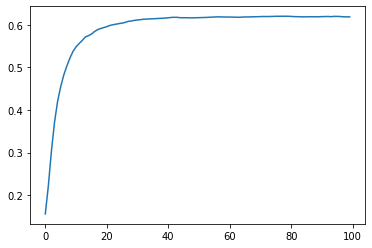

In [83]:
weights = init_param((28*28, 10))
bias = init_param(10)
params = weights,bias
lr = 1e-1
val_acc=(train_model(linear1, lr, params, 100))
plt.plot(range(100), val_acc)